(latent-change-notebook)=
# Modello LCS univariato

I *Latent Change Score Models* (LCSM; McArdle, 2001, 2009; McArdle & Hamagami, 2001) costituiscono un ulteriore sviluppo dei modelli dedicati all'analisi dei dati longitudinali. Per chiarire la differenza tra i modelli LGM e i modelli LCSM, è importante considerare come entrambi modellino il cambiamento nel tempo.

I modello LGM sono utilizzati per descrivere le traiettorie di crescita di una variabile nel tempo. In un LGM, la variabile latente (che rappresenta il cambiamento) è modellata direttamente attraverso diverse misurazioni nel tempo. Questi modelli cercano di catturare il pattern di crescita o declino di una variabile (ad esempio, l'abilità cognitiva o un sintomo clinico) attraverso diversi momenti. Un LGM si concentra sull'intero percorso della variabile e sull'interpretazione di come questa traiettoria cambia in risposta a vari fattori.

I modelli LCSM, d'altra parte, mettono l'accento sul *cambiamento* specifico che avviene tra due momenti consecutivi nel tempo. Questi modelli sono particolarmente utili quando l'interesse è focalizzato su come e perché una variabile cambia da un momento all'altro. Invece di guardare la traiettoria generale come nei LGM, i modelli LCSM esaminano il cambiamento incrementale, consentendo una maggiore comprensione delle dinamiche del cambiamento. I modelli LCSM si concentrano su come i cambiamenti in una variabile (ad esempio, l'abilità cognitiva) da un momento all'altro sono associati a fattori esterni o ad altre variabili misurate.

Mentre i modelli LGM sono usati per studiare la progressione generale di un fenomeno nel tempo, i modelli LCSM sono invece utilizzati per indagare come e perché avviene il cambiamento in risposta a vari fattori. Inoltre, i modelli LCSM forniscono un'analisi più granulare del cambiamento, separando il cambiamento intra-individuale dalla variabilità inter-individuale e consentendo un'esplorazione più dettagliata delle dinamiche del cambiamento.

In questo capitolo esamineremo i modelli LCSM univariati; nel prossimo capitolo ci occuperemo del caso bivariato.

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
    library("lcsm")
    library("tidyr")
    library("stringr")
    library("reshape2")
})

## Analisi di una Misura Unica in Due Momenti Temporali

Esplorare il caso più semplice di una singola variabile misurata in due diversi momenti nel tempo. Immaginiamo un ricercatore che studia un aspetto psicologico, osservando questa variabile in due distinti periodi, identificati come Tempo 1 (T1) e Tempo 2 (T2), su un gruppo di soggetti. L'approccio convenzionale per analizzare se i punteggi di un gruppo di individui sono variati tra T1 e T2 è quello di utilizzare il test t di Student per dati appaiati. Questo test è stato ampiamente utilizzato per confrontare le medie di due misurazioni correlate, come i punteggi di uno stesso gruppo di individui in due momenti diversi. Questo metodo permette di stabilire se ci sia stata una variazione significativa nei punteggi medi del gruppo tra i due momenti osservati. Il modello Latent Change Score (LCS) offre una prospettiva più avanzata e dettagliata rispetto al test t tradizionale. Questo modello permette non solo di valutare se ci sia stata una variazione nei punteggi medi, ma anche di esaminare la natura di questa variazione su base individuale. Mentre il test t tradizionale si concentra sul cambiamento a livello di gruppo, il modello LCS ci consente di indagare come e perché ogni singolo individuo nel campione possa aver sperimentato un cambiamento tra T1 e T2.

Iniziamo simulando i dati mediante lo script fornito da {cite:t}`kievit2018developmental`.

In [2]:
samplesize <- 100

ULCS_simulate <- '

##### The following lines specify the core assumptions of the LCS 
##### and should not generally be modified

COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
dCOG1 =~ 1*COG_T2     # Fixed regression of dCOG1 on COG_T2
COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0  


###### The following five parameters will be estimated in the model. 
###### Values can be modified manually to examine the effect on the model

dCOG1 ~ 4*1         # This fixes the intercept of the change score to 10 
COG_T1 ~ 10*1       # This fixes the intercept of COG_T1 to 50 

dCOG1 ~~ 5*dCOG1    # This fixes the variance of the change scores to 5. 
COG_T1 ~~ 8*COG_T1  # This fixes the variance of the COG_T1 to 8. 

dCOG1 ~ -0.1*COG_T1 # This fixes the self-feedback parameter to -0.1. 
'

In [3]:
set.seed(42)
simdatULCS <- simulateData(ULCS_simulate, sample.nobs = samplesize, meanstructure = TRUE) 
head(simdatULCS)

,COG_T2,COG_T1
,<dbl>,<dbl>
1,9.673594,5.047393
2,15.824384,10.192440
3,10.870739,10.273960
4,12.686939,6.160675
5,11.054693,9.764821
6,13.444989,10.145172


In [4]:
print(colMeans(simdatULCS)) # sanity check the means

  COG_T2   COG_T1 
12.81156 10.02172 


Interpretiamo i valori precedenti come le medie calcolate sulla base dei risultati di 100 soggetti dei punteggi di un ipotetico test cognitivo nei momenti T1 e T2.

Da un punto di vista matematico, modelliamo i punteggi di un individuo $i$ sul costrutto di interesse COG al tempo $t$ come risultato di una componente autoregressiva più un residuo. Stabilendo un peso di regressione di 1 per COG_T2 rispetto a COG_T1, l'equazione autoregressiva diventa:

$$
COG_{i,t2} = COG_{i,t1} + \Delta COG_{i,1}.
$$

Questa formulazione indica che il punteggio di COG al tempo 2 (COG_{i,t2}) è uguale al punteggio al tempo 1 (COG_{i,t1}) più un cambiamento latente ($\Delta COG_{i,1}$).

Il cambiamento latente può essere definito come:

$$
\Delta COG_{i,1} = COG_{i,t2} - COG_{i,t1}.
$$

In questo contesto, all'interno dei modelli SEM, si introduce un fattore latente $\Delta COG1$, che rappresenta il cambiamento tra il tempo 1 e il tempo 2. Questo fattore latente è identificato al tempo 2 con un carico fattoriale fissato a 1, catturando così il cambiamento osservato.

È poi possibile aggiungere un parametro di regressione $\beta$ al modello, per indagare se il grado di cambiamento dipenda dai punteggi al tempo 1:

$$
\Delta COG_{i,1} = \beta \cdot COG_{i,t1}.
$$

Con questo modello, possiamo rispondere a tre questioni fondamentali. La prima riguarda l'esistenza di un cambiamento medio significativo da T1 a T2, misurato dalla media del fattore di cambiamento latente, $\mu_{\Delta COG1}$. Questo approccio può essere considerato equivalente a un test t di Student per dati appaiati sotto determinate condizioni. Oltre a questo, il modello permette di stimare la varianza del fattore di cambiamento, $\sigma^2_{\Delta COG1}$, che riflette quanto gli individui differiscono nel cambiamento nel tempo. Infine, si può specificare un parametro autoregressivo o una covarianza $\beta$, che quantifica la dipendenza del cambiamento dai punteggi iniziali.

In sintesi, il modello LCS fornisce un quadro robusto per analizzare i cambiamenti nel tempo in un costrutto latente, offrendo sia una stima del cambiamento medio sia una misura della varianza individuale in questo cambiamento, e valutando l'effetto dei punteggi iniziali sul cambiamento stesso.

Il modello LCS può essere formulato in `lavaan` nel modo seguente.

In [5]:
ULCS <- '
    COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2     # Fixed loading of dCOG1 on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0 

    dCOG1 ~ 1             # This estimates the intercept of the change scores 
    COG_T1 ~ 1            # This estimates the intercept of COG_T1 
    dCOG1 ~~ dCOG1        # This estimates the variance of the change scores 
    COG_T1 ~~ COG_T1      # This estimates the variance of COG_T1 
    dCOG1 ~ COG_T1        # This estimates the self-feedback parameter
'

Il modello di Latent Change Score (LCS) può essere riformulato e chiarito nel seguente modo:

```R
ULCS <- '
    COG_T2 ~ 1*COG_T1     # Regressione fissa di COG_T2 su COG_T1
    dCOG1 =~ 1*COG_T2     # Carico fattoriale fisso di dCOG1 su COG_T2
    COG_T2 ~ 0*1          # Fissa l'intercetta di COG_T2 a 0
    COG_T2 ~~ 0*COG_T2    # Fissa la varianza di COG_T2 a 0

    dCOG1 ~ 1             # Stima l'intercetta dei punteggi di cambiamento
    COG_T1 ~ 1            # Stima l'intercetta di COG_T1
    dCOG1 ~~ dCOG1        # Stima la varianza dei punteggi di cambiamento
    COG_T1 ~~ COG_T1      # Stima la varianza di COG_T1
    dCOG1 ~ COG_T1        # Stima il parametro di auto-feedback
'
```

Spiegazione delle Componenti del Modello:

1. **COG_T2 ~ 1*COG_T1**: Questa riga indica che il punteggio cognitivo al tempo T2 (COG_T2) è previsto linearmente dal punteggio al tempo T1 (COG_T1). In pratica, ogni variazione in COG_T1 si riflette direttamente in una variazione equivalente in COG_T2.

2. **dCOG1 =~ 1*COG_T2**: Qui, dCOG1, che rappresenta il cambiamento latente della variabile cognitiva tra T1 e T2, è modellato con un carico fattoriale fisso su COG_T2. Questo significa che dCOG1 misura il cambiamento osservato da T1 a T2.

3. **COG_T2 ~ 0*1 e COG_T2 ~~ 0*COG_T2**: Queste righe indicano che l'intercetta e la varianza di COG_T2 sono fissate a 0, suggerendo che non esistono variazioni in COG_T2 al di fuori di quelle spiegate dalla sua relazione con COG_T1.

4. **dCOG1 ~ 1 e COG_T1 ~ 1**: Queste righe stimano rispettivamente le intercette di dCOG1 (il cambiamento latente) e COG_T1, fornendo valori medi per queste misurazioni.

5. **dCOG1 ~~ dCOG1 e COG_T1 ~~ COG_T1**: Queste righe stimano le varianze di dCOG1 e COG_T1, mostrando la variabilità nel cambiamento e nella misura iniziale rispettivamente.

6. **dCOG1 ~ COG_T1**: Questa linea introduce un parametro di regressione che esplora come il punteggio iniziale (COG_T1) influisce sul cambiamento latente (dCOG1), permettendo di indagare la dipendenza del cambiamento dai punteggi iniziali.

Il corrispondente diagramma di percorso è fornito nella figura seguente.

```{figure} ../images/kevit_1.png
---
height: 400px
name: kevit1-fig
---
**Diagramma di percorso semplificato di un LCSM univariato.** La variabile COG viene misurata in due momenti (COG_T1 e COG_T2). Il cambiamento (ΔCOG1) tra i due momenti viene modellato come una variabile latente. (La figura è tratta da {cite:t}`kievit2018developmental`.)
```

Adattiamo il modello specificato ai dati dell'esempio.

In [6]:
fitULCS <- lavaan(ULCS, data=simdatULCS, estimator='mlr', fixed.x=FALSE, missing='fiml')

In [7]:
summary(fitULCS, fit.measures = TRUE, standardized = TRUE, rsquare = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 37 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         5

  Number of observations                           100
  Number of missing patterns                         1

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                 0.000       0.000
  Degrees of freedom                                 0           0

Model Test Baseline Model:

  Test statistic                               105.669      85.223
  Degrees of freedom                                 1           1
  P-value                                        0.000       0.000
  Scaling correction factor                                  1.240

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000       1.000
  Tucker-Lewis Index (TLI)                       

- Il cambiamento nel punteggio latente tra i momenti T1 e T2 è stimato essere uguale a 3.166 (SE = 0.648). Questo valore può essere messo in relazione alla differenza tra le medie dei punteggi in due momenti temporali che viene calcolata da un test t di Student per dati appaiati. Si noti però che, mentre nel caso del test t la differenza riguarda i punteggi osservati, nei modelli LSC essa descrive la variazione tra i punteggi latenti nei momenti T1 e T2.

In [8]:
t.test(x = simdatULCS$COG_T1, y = simdatULCS$COG_T2)


	Welch Two Sample t-test

data:  simdatULCS$COG_T1 and simdatULCS$COG_T2
t = -6.1614, df = 192.21, p-value = 4.142e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.682920 -1.896764
sample estimates:
mean of x mean of y 
 10.02172  12.81156 


- Il coefficiente 4.140 (SE = 0.733) stima la varianza con la quale gli individui differiscono nel cambiamento che manifestano nel tempo. 

- Infine, il coefficiente -0.038 (SE = 0.064) stima la componente autoregressiva dal tempo T1 al tempo T2.

Mediante `semPaths` possiamo generare il corrispondente diagramma di percorso.

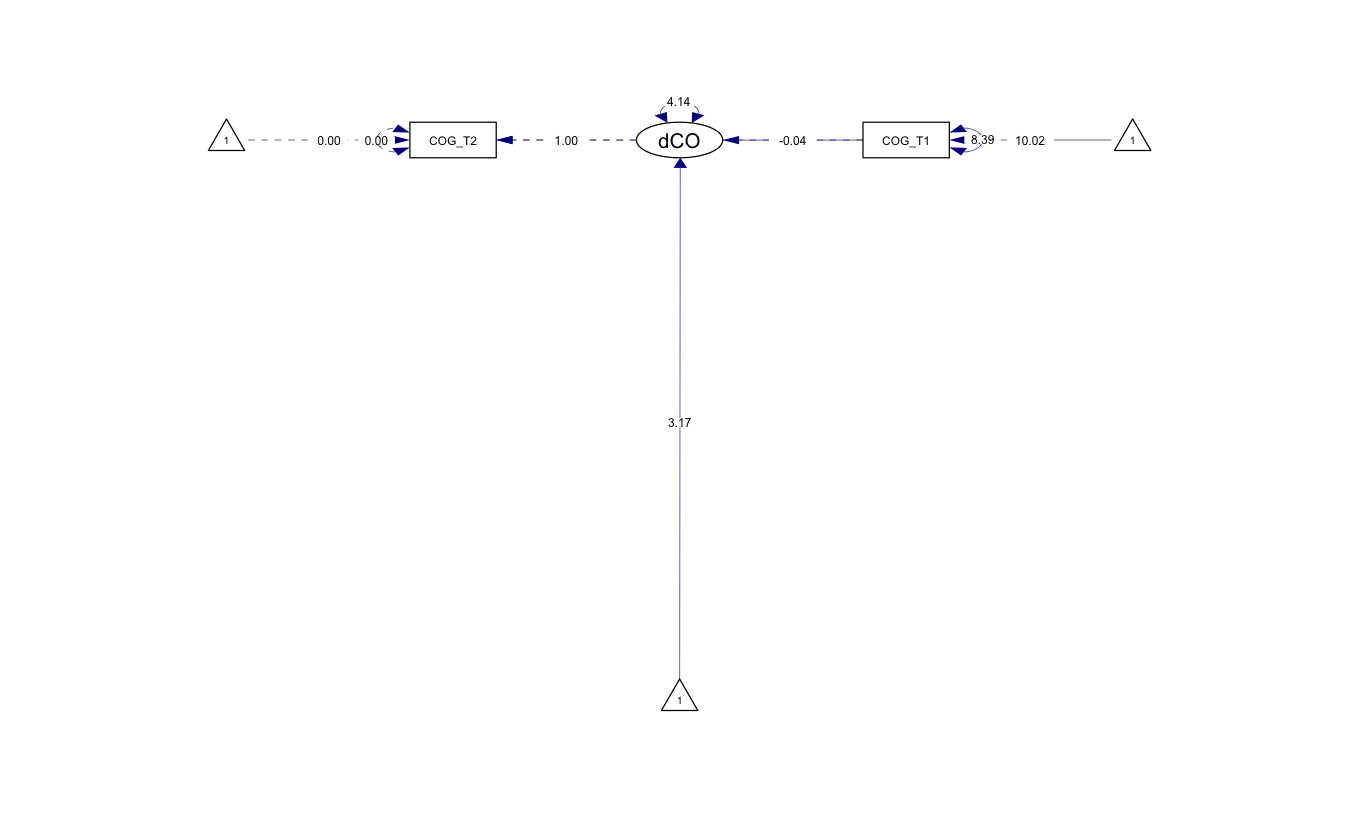

In [9]:
fitULCS |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE,
        node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

## Indicatori multipli in due rilevazioni temporali

Consideriamo ora il caso in cui abbiamo indicatori multipli in due momenti del tempo. Iniziamo con la simulazione dei dati mediante lo script fornito da {cite:t}`kievit2018developmental`.

In [10]:
samplesize <- 100

#Simulate data for a Univariate Latent Change Score model. 
MILCS_simulate <- '
    ####    The following two lines specify the measurement model for multiple indicators (X1-X3) 
    ####    measured on two occasions (T1-T2)
    COG_T1=~.8*T1X1+.9*T1X2+.7*T1X3   # This specifies the measurement model for COG_T1 
    COG_T2=~.8*T2X1+.9*T2X2+.7*T2X3   # This specifies the measurement model for COG_T2 

    #####     The following lines specify the core assumptions of the LCS 
    #####     and should not generally be modified

    COG_T2 ~ 1*COG_T1           # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2           # Fixed regression of dCOG1 on COG_T2
    COG_T2 ~ 0*1                # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2          # This fixes the variance of the COG_T2 to 0  

    T1X1~0*1                  # This fixes the intercept of X1 to 0
    T1X2~1*1                  # This fixes the intercept of X2 to 1
    T1X3~.5*1                 # This fixes the intercept of X3 to 0.5 
    T2X1~0*1                  # This fixes the intercept of X1 to 0
    T2X2~1*1                  # This fixes the intercept of X2 to 1
    T2X3~.5*1                 # This fixes the intercept of X3 to 0.5

    ###### The following five parameters will be estimated in the model. 
    ###### Values can be modified manually to examine the effect on the model

    dCOG1 ~ 10*1            # This fixes the intercept of the change score to 10 
    COG_T1 ~ 50*1           # This fixes the intercept of COG_T1 to 50. 
    dCOG1 ~~ 5*dCOG1        # This fixes the variance of the change scores to 5. 
    COG_T1 ~~ 8*COG_T1      # This fixes the variance of the COG_T1 to 8. 
    dCOG1 ~ -0.1*COG_T1       # This fixes the self-feedback parameter to -0.1. 
'

Simuliamo i dati.

In [11]:
set.seed(123)
simdatMILCS <- simulateData(MILCS_simulate, sample.nobs = samplesize, meanstructure = TRUE) 

Queste sono le medie delle tre variabili nei due momenti temporali.

In [12]:
print(colMeans(simdatMILCS))

    T1X1     T1X2     T1X3     T2X1     T2X2     T2X3 
39.89147 45.96496 35.41306 43.77188 50.13512 38.59128 


Esaminiamo la variazione dei punteggi dei soggetti.

Using id, Indicator as id variables



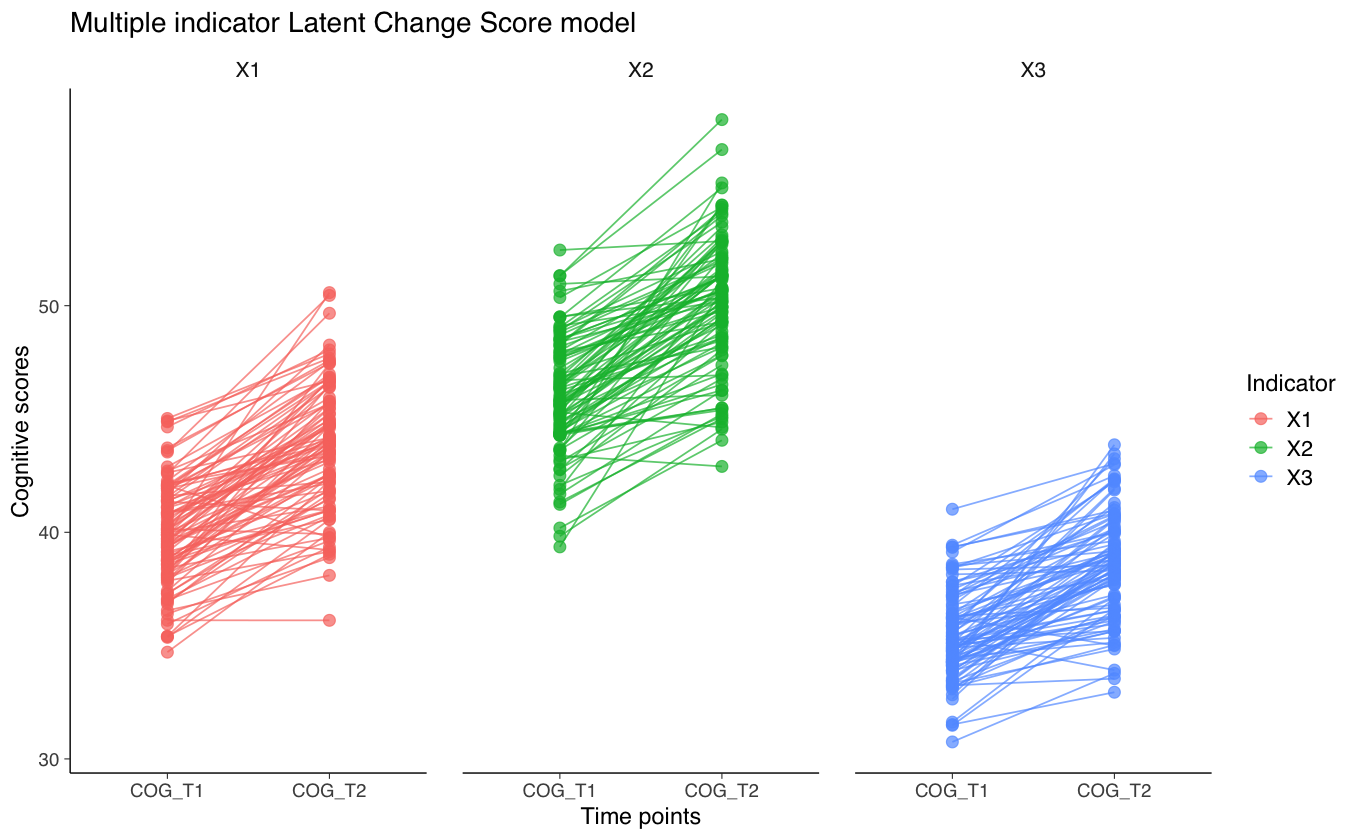

In [13]:
id <- factor(1:samplesize)
plotdattemp <- data.frame(
    c(simdatMILCS$T1X1, simdatMILCS$T1X2, simdatMILCS$T1X3),
    c(simdatMILCS$T2X1, simdatMILCS$T2X2, simdatMILCS$T2X3),
    as.factor(c(id, id, id)),
    c(
        rep("X1", times = samplesize),
        rep("X2", times = samplesize),
        rep("X3", times = samplesize)
    )
)
colnames(plotdattemp) <- c("COG_T1", "COG_T2", "id", "Indicator")
plotdat <- melt(plotdattemp, by = "id")
ggplot(plotdat, aes(variable, value, group = id, col = Indicator)) +
    geom_point(size = 3, alpha = .7) +
    geom_line(alpha = .7) +
    ggtitle("Multiple indicator Latent Change Score model") +
    ylab("Cognitive scores") +
    xlab("Time points") +
    facet_grid(~Indicator)

Definiamo il modello LCS per indicatori multipli e due momenti temporali mediante il codice fornito da {cite:t}`kievit2018developmental`.

In [14]:
MILCS <- '
    COG_T1 =~ 1*T1X1+T1X2+T1X3  # This specifies the measurement model for COG_T1 
    COG_T2 =~ 1*T2X1+equal("COG_T1=~T1X2")*T2X2+equal("COG_T1=~T1X3")*T2X3   # This specifies the measurement model for COG_T2 with the equality constrained factor loadings

    COG_T2 ~ 1*COG_T1     # Fixed regression of COG_T2 on COG_T1
    dCOG1 =~ 1*COG_T2     # Fixed regression of dCOG1 on COG_T2
    COG_T2 ~ 0*1          # This line constrains the intercept of COG_T2 to 0
    COG_T2 ~~ 0*COG_T2    # This fixes the variance of the COG_T2 to 0 

    dCOG1 ~ 1             # This estimates the intercept of the change score 
    COG_T1 ~  1           # This estimates the intercept of COG_T1 
    dCOG1 ~~ dCOG1        # This estimates the variance of the change scores 
    COG_T1 ~~ COG_T1      # This estimates the variance of the COG_T1 
    dCOG1~COG_T1          # This estimates the self-feedback parameter

    T1X1~~T2X1   # This allows residual covariance on indicator X1 across T1 and T2
    T1X2~~T2X2   # This allows residual covariance on indicator X2 across T1 and T2
    T1X3~~T2X3   # This allows residual covariance on indicator X3 across T1 and T2

    T1X1~~T1X1   # This allows residual variance on indicator X1 
    T1X2~~T1X2   # This allows residual variance on indicator X2
    T1X3~~T1X3   # This allows residual variance on indicator X3

    T2X1~~equal("T1X1~~T1X1")*T2X1  # This allows residual variance on indicator X1 at T2 
    T2X2~~equal("T1X2~~T1X2")*T2X2  # This allows residual variance on indicator X2 at T2 
    T2X3~~equal("T1X3~~T1X3")*T2X3  # This allows residual variance on indicator X3 at T2

    T1X1~0*1                 # This constrains the intercept of X1 to 0 at T1
    T1X2~1                   # This estimates the intercept of X2 at T1
    T1X3~1                   # This estimates the intercept of X3 at T1
    T2X1~0*1                 # This constrains the intercept of X1 to 0 at T2
    T2X2~equal("T1X2~1")*1   # This estimates the intercept of X2 at T2
    T2X3~equal("T1X3~1")*1   # This estimates the intercept of X3 at T2
'

Il modello "MILCS" rappresenta un'estensione del caso precedente, che riguardava un singolo indicatore in due momenti temporali. 

**Modello di Misura per COG_T1 e COG_T2**: Nel modello MILCS, COG_T1 e COG_T2 sono costruiti usando più indicatori (T1X1, T1X2, T1X3 per COG_T1 e T2X1, T2X2, T2X3 per COG_T2). Questo offre una comprensione più ricca di ogni misurazione cognitiva, catturando diverse sfaccettature o aspetti in ciascun momento temporale.

Vengono introdotti vari vincoli per l'identificazione del modello.

1. **Vincoli di Regressione e delle Intercette**: Come nel modello precedente, la regressione di COG_T2 su COG_T1 è fissata e l'intercetta di COG_T2 è vincolata a 0, così come la varianza di COG_T2.

2. **Vincoli di Carico Fattoriale Uguale**: Un aspetto nuovo di MILCS è l'uso di vincoli di eguaglianza sulle saturazioni fattoriali degli indicatori corrispondenti di COG_T1 e COG_T2 (ad es., `equal("COG_T1=~T1X2")*T2X2`). Questo assicura che gli indicatori misurino lo stesso costrutto in modo consistente attraverso i due tempi.

3. **Covarianza Residua e Varianza degli Indicatori**: Il modello permette covarianze residue tra gli stessi indicatori attraverso i tempi (es. T1X1~~T2X1) e stima la varianza residua per ogni indicatore in entrambi i momenti temporali.

4. **Stima degli Intercette degli Indicatori**: Vengono fissati vincoli sulle intercette degli indicatori. Il vincolo `T1X1~0*1` fissa l'intercetta dell'indicatore T1X1 a 0. Questo significa che, per l'indicatore T1X1, il punto di partenza o il valore di base è impostato a zero. Questo fornisce un punto di riferimento standardizzato per l'analisi degli indicatori all'interno del modello. Al contrario, le intercette per altri indicatori come T1X2 sono stimate liberamente, permettendo al modello di adattarsi meglio ai dati.

Il modello consente di interpretare il cambiamento non solo in termini di un'unica misurazione globale, ma attraverso varie dimensioni, fornendo insight più dettagliati sulle dinamiche del cambiamento cognitivo.

Il corrispondente diagramma di percorso è fornito nella figura seguente.

```{figure} ../images/kievit_2.jpg
---
height: 550px
name: kevit2-fig
---
**Diagramma di percorso di un LCSM univariato con indicatori multipli.** Il costrutto latente di interesse (COG) viene misurato in due momenti temporali (COG_T1 e COG_T2), ciascuno utilizzando tre indicatori (X1, X2, X3). Si assume l'invarianza della misurazione e gli errori residui correlati nel tempo. (La figura è tratta da {cite:t}`kievit2018developmental`.)
```

Adattiamo il modello ai dati.

In [15]:
fitMILCS <- lavaan(MILCS, data=simdatMILCS, estimator='mlr', fixed.x=FALSE, missing='fiml')

Esaminiamo la soluzione.

In [16]:
summary(fitMILCS, fit.measures = TRUE, standardized = TRUE, rsquare = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 62 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        22
  Number of equality constraints                     7

  Number of observations                           100
  Number of missing patterns                         1

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                10.053      10.011
  Degrees of freedom                                12          12
  P-value (Chi-square)                           0.611       0.615
  Scaling correction factor                                  1.004
    Yuan-Bentler correction (Mplus variant)                       

Model Test Baseline Model:

  Test statistic                               610.567     592.305
  Degrees of freedom                                15          15
  P-value                     

- L'intercetta di dCOG1, che è 7.885 con un errore standard di 3.207, rappresenta il valore medio stimato del cambiamento latente (dCOG1) nel campione. Questo numero indica la media generale del cambiamento osservato, considerando tutti gli individui nel campione.

- La varianza di dCOG1, che è 3.230 con un errore standard di 0.675, descrive la varianza nel cambiamento del costrutto tra gli individui nel tempo. Questo valore indica quanto gli individui differiscono nel loro cambiamento, riflettendo l'eterogeneità del cambiamento nel campione.

- Il coefficiente di -0.100 con un errore standard di 0.079 nella regressione di dCOG1 su COG_T1 rappresenta il parametro autoregressivo, che indica l'effetto della misura iniziale (COG_T1) sul cambiamento (dCOG1). Un valore negativo suggerisce che valori più alti di COG_T1 sono associati a una riduzione nel cambiamento (dCOG1), ma poiché il valore p (0.206) non è significativo, non possiamo confermare con sicurezza questa relazione nel modello.

I valori di CFI e TLI molto vicini o uguali a 1, RMSEA e SRMR molto bassi, e un p-value elevato per il test di chi-quadrato indicano un buon adattamento del modello ai dati. Questi risultati suggeriscono che il modello specificato si adatta bene ai dati osservati.

Generiamo il diagramma di percorso.

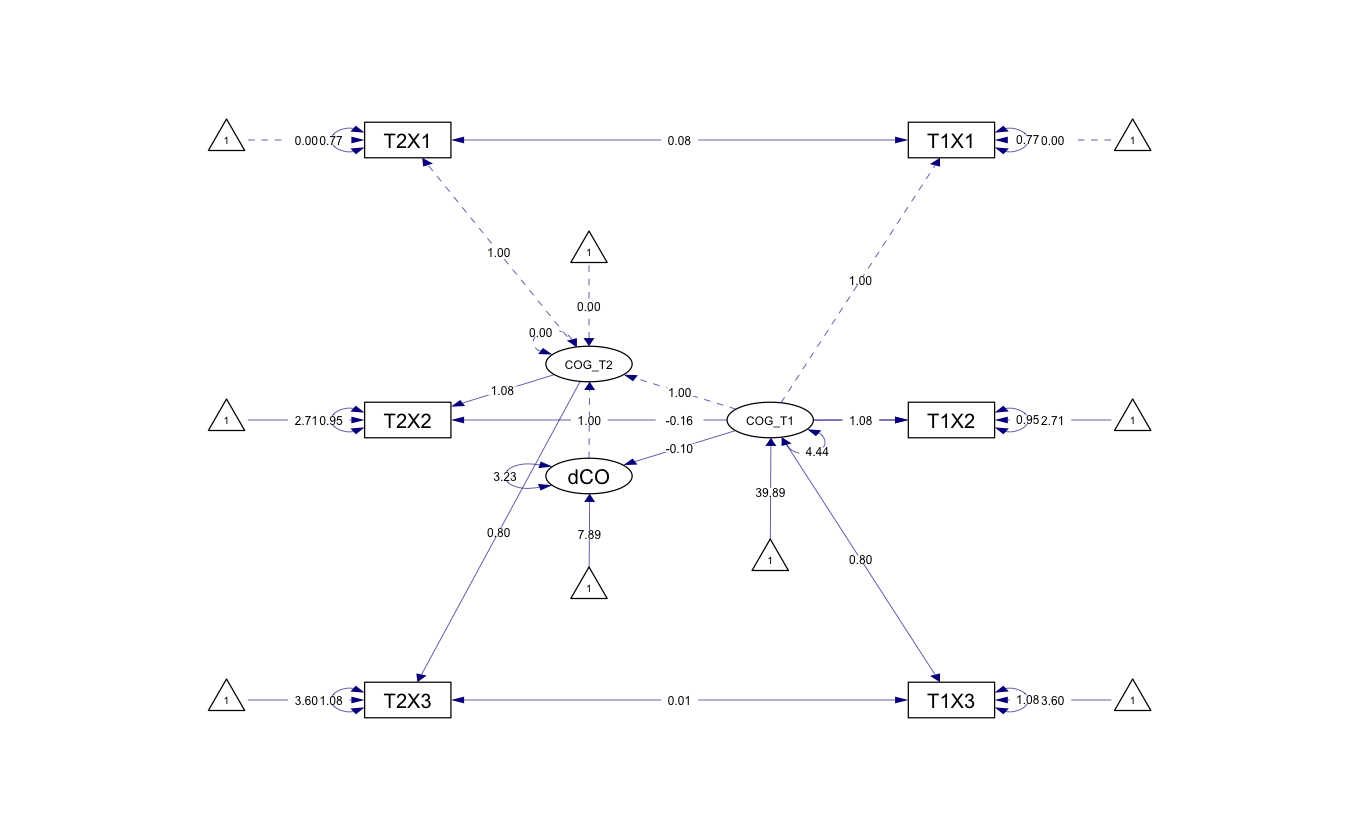

In [17]:
fitMILCS |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE,
        node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

## Modello di cambiamento duale

In questo secondo esempio fornito da {cite}`wiedemann2022lcsm` estenderemo l'approccio illustrato in precedenza. Useremo inoltre le funzionalità del pacchetto R `lcsm` fornito dagli stessi autori per specificare il modello LCS univariato in un caso più complesso di quello esaminato nel primo esempio.

Il modello LCS univariato descritto ora si pone il problema di descrivere i cambiamenti degli individui ($i$) in un costrutto ($X$) in una serie di momenti del tempo ($t$). La figura successiva riporta il diagramma di percorso fornito da {cite:t}`wiedemann2022lcsm`.

```{figure} ../images/lcsm_1.png
---
height: 450px
name: lcsm1-fig
---
**Diagramma di percorso semplificato di LCSM univariato.** Quadrati bianchi = punteggi osservati sulla variabile $x$ nei punti temporali da 1 a 5; cerchi verdi = punteggi veri latenti (prefisso ‘l’); cerchi blu = punteggi di cambiamento latenti (prefisso ‘d’); cerchio giallo = fattore di cambiamento latente costante. Frecce direzionali = regressioni; frecce bidirezionali = covarianze. Parametro `beta_x` = fattore di cambiamento proporzionale; parametro `phi_x` = autoregressione dei punteggi di cambiamento; parametro `sigma_g2lx1` = covarianza del fattore di cambiamento (`g2`) con il punteggio vero iniziale (`lx1`). I punteggi unici ($ux_t$) e le varianze uniche ($σ^2_{ux}$) non sono mostrati nella figura per semplicità.
```

Come indicato in precedenza, i modelli  LCS descrivono il cambiamento di un costrutto nel tempo mediante tre parametri: 

- un parametro di cambiamento costante ($α_x \cdot s_{xi}$), 
- un parametro di cambiamento proporzionale ($β_x \cdot x_{[t−1]i}$),
- un effetto autoregressivo dei punteggi di cambiamento ($ϕ_x \cdot ∆x_{[t−1]i}$). 
  
Il cambiamento in un costrutto (X) in un punto temporale specifico (t) è specificato dalla seguente equazione che include i tre parametri precedenti:

$$
∆x_{[t]i} = \alpha_x \cdot s_{xi} + \beta_x \cdot x_{[t−1]i} + ϕ_x \cdot ∆x_{[t−1]i}.
$$

- Il parametro di cambiamento costante ($α_x$) è simile al cambiamento in un modello lineare, perché ha lo stesso effetto su tutti i punteggi di cambiamento (si vedano i percorsi identici che conducono da `g2` a ciascun punteggio di cambiamento `dx2` a `dx5` nella figura precedente). 
- Il parametro di cambiamento proporzionale ($β_x$) descrive se il “punteggio di cambiamento” al tempo ($t$) è determinato dal “punteggio vero” dello stesso costrutto al punto temporale precedente ($t-1$) -- si vedano i percorsi etichettati `beta_x` nella figura. Il cambiamento viene detto "proporzionale" perché i cambiamenti previsti sono proporzionali allo stato del punteggio vero nel momento temporale precedente. 
- Le autoregressioni dei punteggi di cambiamento descrivono se un dato punteggio di cambiamento sono determinate dal punteggio di cambiamento precedente (si vedano i percorsi etichettati `phi_x` nella figura). 

Si noti che in questo esempio tutti i parametri sono vincolati ad essere uguali nel tempo.

Questo modello viene chiamato modello di cambiamento duale ed è il modello LCS più comunemente usato per dati longitudinali. Questo modello include quello che viene spesso definito come un effetto maturativo ($g2_i$), così come l’effetto di cambiamento proporzionale ($\beta_x$). Il modello di cambiamento duale produce una traiettoria di crescita esponenziale che dipende dal segno e dalla grandezza di $g2_i$, $\beta_x$ e $lx1_i$ (si veda Grimm, An, McArdle, Zonderman e Resnick, 2012). 

Per illustrare l’adattamento e l’interpretazione del modello di cambiamento duale, analizziamo i dati longitudinali di matematica che sono stati utilizzati nel Capitolo 3 di {cite:p}`grimm2016growth`. I dati longitudinali di matematica sono stati raccolti dall’NLSY-CYA (Center for Human Resource Research, 2009) e i punteggi di matematica provengono dal PIAT (Dunn & Markwardt, 1970). Il grado scolastico al momento del test viene utilizzato come metrica temporale e varia dalla seconda elementare (grado 2) alla terza media (grado 8). 

Importiamo i dati in R.

In [18]:
#set filepath
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
#read in the text data file using the url() function
nlsy_data <- read.table(file=url(filepath),na.strings = ".")

#adding names for the columns of the data set
names(nlsy_data) <- c('id', 'female', 'lb_wght', 'anti_k1', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8', 'age2', 'age3', 'age4', 'age5', 'age6', 'age7', 'age8', 'men2', 'men3', 'men4', 'men5', 'men6', 'men7', 'men8', 'spring2', 'spring3', 'spring4', 'spring5', 'spring6', 'spring7', 'spring8', 'anti2', 'anti3', 'anti4', 'anti5', 'anti6', 'anti7', 'anti8')

#reduce data down to the id variable and the math and reading variables of interest
nlsy_uni_data <- nlsy_data[ ,c('id', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7', 'math8')]

Otteniamo le statistiche descrittive.

In [19]:
psych::describe(nlsy_uni_data) |>
    print()

      vars   n      mean        sd   median   trimmed       mad min     max
id       1 933 532334.90 328020.79 506602.0 520130.77 391999.44 201 1256601
math2    2 335     32.61     10.29     32.0     32.28     10.38  12      60
math3    3 431     39.88     10.30     41.0     39.88     10.38  13      67
math4    4 378     46.17     10.17     46.0     46.22      8.90  18      70
math5    5 372     49.77      9.47     48.0     49.77      8.90  23      71
math6    6 390     52.72      9.92     50.5     52.38      9.64  24      78
math7    7 173     55.35     10.63     53.0     55.09     11.86  31      81
math8    8 142     57.83     11.53     56.0     57.43     12.60  26      81
        range  skew kurtosis       se
id    1256400  0.28    -0.91 10738.92
math2      48  0.27    -0.46     0.56
math3      54 -0.05    -0.33     0.50
math4      52 -0.06    -0.08     0.52
math5      48  0.04    -0.34     0.49
math6      54  0.25    -0.38     0.50
math7      50  0.21    -0.97     0.81
math8      5

Selezioneremo dal data set solo le variabili 'math2', 'math3', 'math4', 'math5', 'math6','math7' e 'math8'.

In [20]:
x_var_list <- paste0("math", 2:8)
x_var_list |>
    print()

[1] "math2" "math3" "math4" "math5" "math6" "math7" "math8"


Esaminiamo le traiettorie di crescita nel campione.

Warning message:
“Removed 2787 rows containing missing values (`geom_line()`).”


Warning message:
“Removed 4310 rows containing missing values (`geom_point()`).”


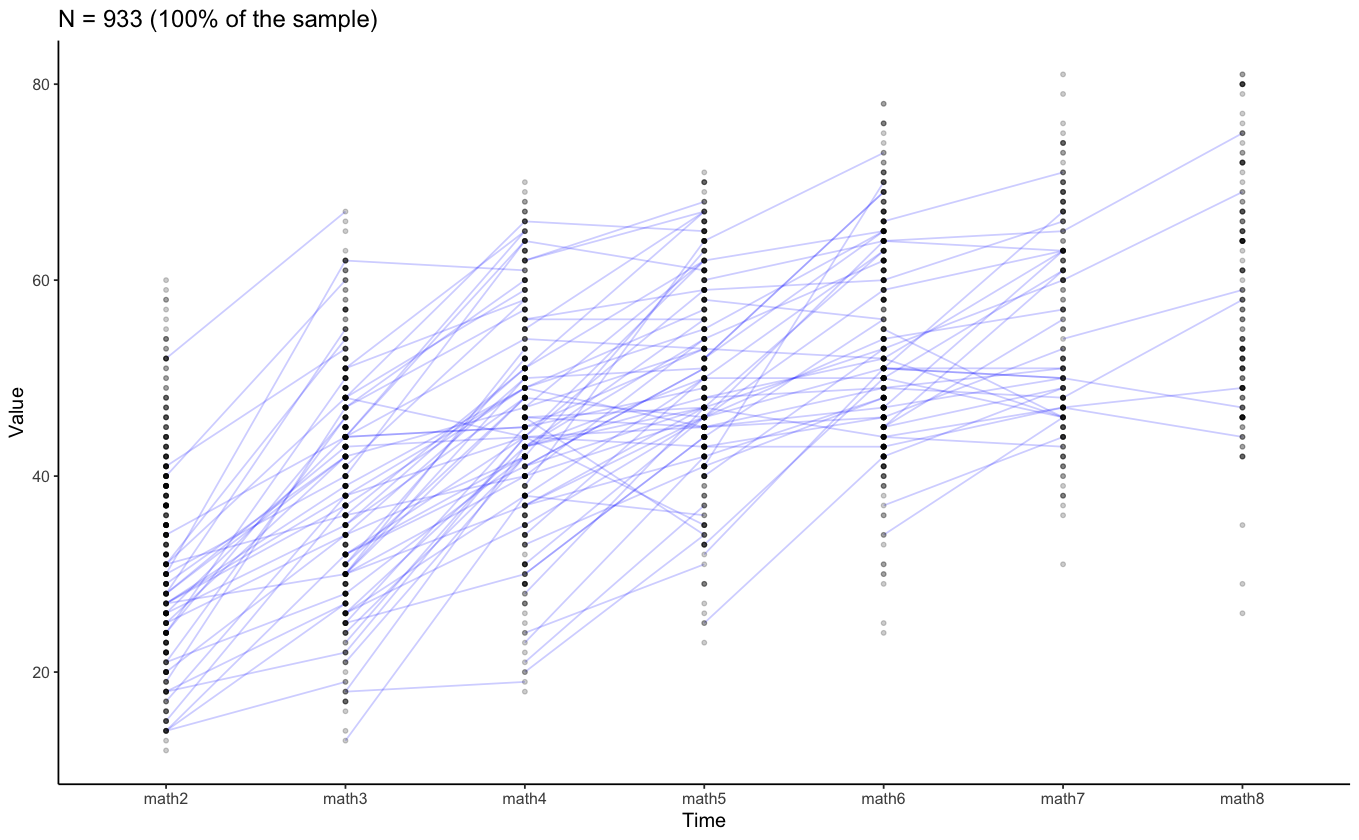

In [21]:
plot_trajectories(
    data = nlsy_uni_data,
    id_var = "id",
    var_list = x_var_list,
    xlab = "Time", ylab = "Value",
    connect_missing = FALSE,
    # random_sample_frac = 0.018,
    title_n = TRUE
)

Esaminiamo i dati di alcuni soggetti presi a caso.

Warning message:
“Removed 35 rows containing missing values (`geom_point()`).”


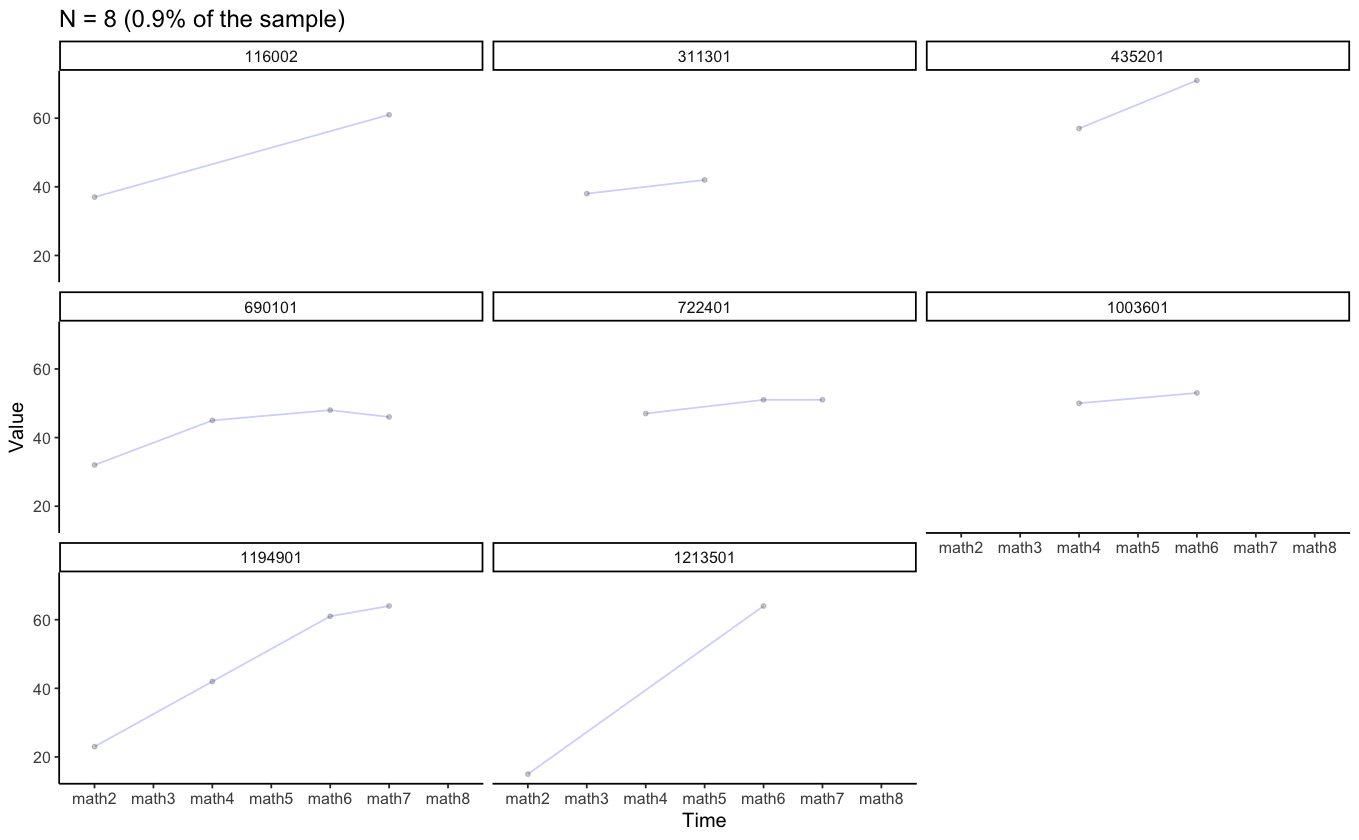

In [22]:
plot_trajectories(
    data = nlsy_uni_data,
    id_var = "id", 
    var_list = x_var_list,
    xlab = "Time", ylab = "Value",
    connect_missing = TRUE, 
    random_sample_frac = 0.009, 
    title_n = TRUE) +
  facet_wrap(~id)

In [23]:
uni_lavaan_results <- fit_uni_lcsm(
    data = nlsy_uni_data, 
    var = x_var_list,
    model = list(alpha_constant = TRUE, 
    beta = TRUE, 
    phi = TRUE)
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


In [24]:
uni_lavaan_syntax <- fit_uni_lcsm(
    data = nlsy_uni_data,
    var = x_var_list,
    model = list(
        alpha_constant = TRUE,
        beta = TRUE,
        phi = TRUE
    ),
    return_lavaan_syntax = TRUE
)

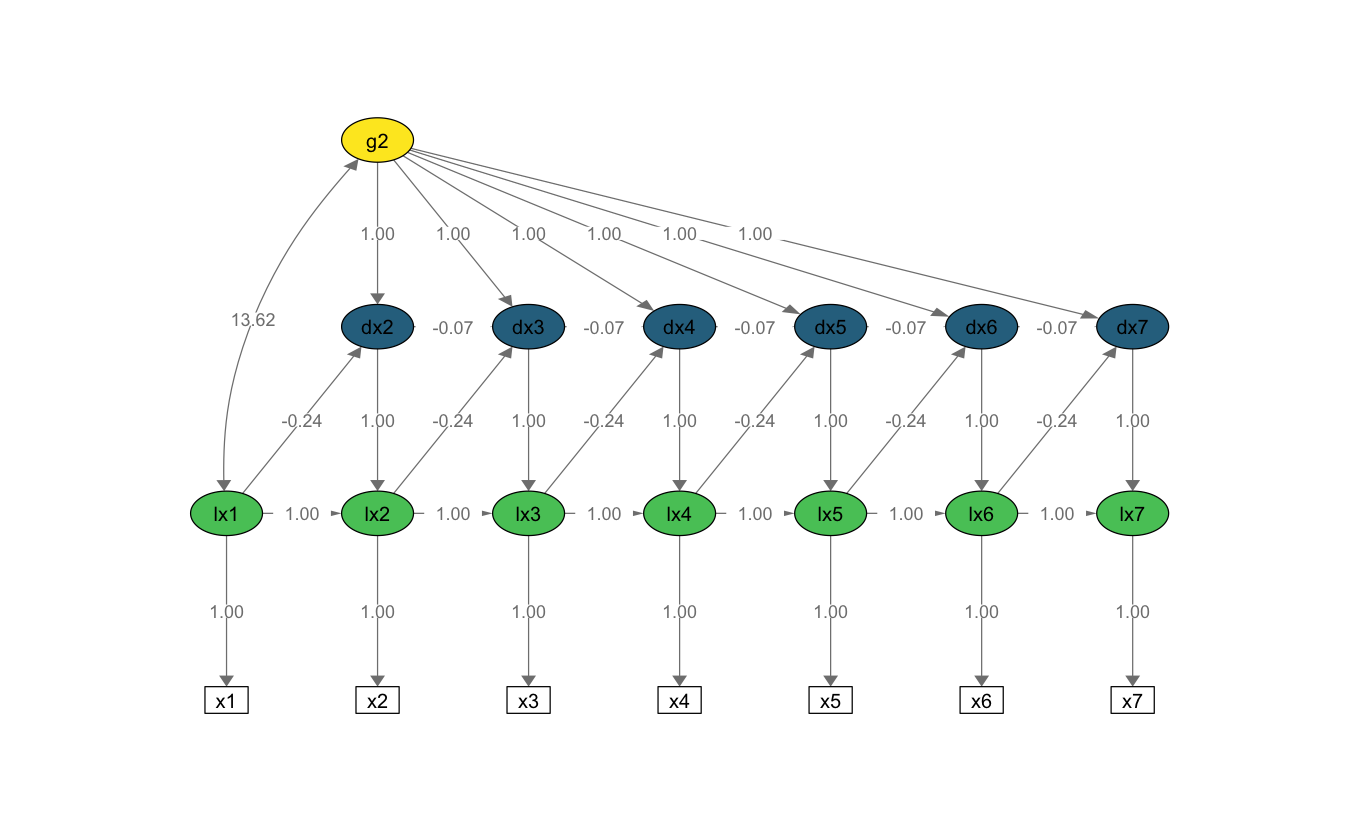

In [25]:
# Plot the results
plot_lcsm(
    lavaan_object = uni_lavaan_results,
    lavaan_syntax = uni_lavaan_syntax,
    edge.label.cex = .9,
    lcsm_colours = TRUE,
    lcsm = "univariate"
)

Esaminiamo la bontà di adattamento.

In [26]:
extract_fit(uni_lavaan_results) |>
    print()

# A tibble: 1 × 8
  model chisq  npar    aic    bic   cfi  rmsea  srmr
  <chr> <dbl> <dbl>  <dbl>  <dbl> <dbl>  <dbl> <dbl>
1 1      57.4     8 15806. 15845. 0.964 0.0347 0.138


Notiamo che le informazioni sull’adattamento del modello fornite da `lcsm` indicano che il modello di cambiamento duale si adatta bene ai dati con forti indici di adattamento globale (ad esempio, RMSEA inferiore a 0.05, CFI > 0.95).

In [27]:
extract_param(uni_lavaan_results) |>
    print()

# A tibble: 8 × 8
  label       estimate std.error statistic  p.value  std.lv std.all std.nox
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>   <dbl>   <dbl>   <dbl>
1 gamma_lx1    32.4       0.463      70.0  0         3.82    3.82    3.82  
2 sigma2_lx1   72.0       6.19       11.6  0         1       1       1     
3 sigma2_ux    30.8       1.76       17.5  0        30.8     0.299   0.299 
4 alpha_g2     15.6       0.955      16.3  0         6.44    6.44    6.44  
5 sigma2_g2     5.84      0.944       6.19 6.13e-10  1       1       1     
6 sigma_g2lx1  13.6       1.68        8.09 6.66e-16  0.664   0.664   0.664 
7 beta_x       -0.242     0.0198    -12.2  0        -1.10   -1.10   -1.10  
8 phi_x        -0.0652    0.0612     -1.07 2.87e- 1 -0.0941 -0.0941 -0.0941


L'output completo è fornito qui di seguito.

In [28]:
summary(uni_lavaan_results) |>
    print()

lavaan 0.6.17 ended normally after 55 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        23
  Number of equality constraints                    15

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                              Standard      Scaled
  Test Statistic                                57.364      59.371
  Degrees of freedom                                27          27
  P-value (Chi-square)                           0.001       0.000
  Scaling correction factor                                  0.966
    Yuan-Bentler correction (Mplus variant)                       

Parameter Estimates:

  Standard errors                             Sandwich
  Information bread     

I parametri stimati del modello di cambiamento duale includono la media del punteggio vero iniziale, `gamma_lx1`. Il valore 32.38 del punteggio vero iniziale rappresenta la media predetta dei punteggi di matematica al grado 2.  La media della componente di cambiamento costante è 15.56 ed è una delle componenti dei cambiamenti previsti nel tempo, con la seconda proveniente dall’effetto di cambiamento proporzionale. Poiché ci sono due aspetti del cambiamento nel modello di cambiamento duale, la media della componente di cambiamento costante può essere difficile da interpretare. Inoltre, la componente di cambiamento costante funziona come un’intercetta nell’equazione di cambiamento, il che rende il suo valore dipendente dalla scala della variabile osservata (cioè, aggiungendo o sottraendo una costante a tutti i punteggi altera la media della componente di cambiamento costante). E poiché la componente di cambiamento costante è un’intercetta nell’equazione di cambiamento, è interpretabile solo quando tutti gli altri predittori (punteggi veri precedenti) sono zero. Nei nostri dati, i punteggi di matematica non sono mai zero in questo set di dati, il che rende la media della componente di cambiamento costante un’estrapolazione dai dati e successivamente difficile da interpretare isolatamente.

A causa di queste limitazioni, descriviamo la forma complessiva dello sviluppo esaminando insieme la media della componente di cambiamento costante e il parametro di cambiamento proporzionale insieme alla media del punteggio vero iniziale. La traiettoria media inizia a 32.38 e aumenta in base a due aspetti: un effetto maturativo di 15.56 (media della componente di cambiamento costante), che viene aggiunto ad ogni grado, e l’effetto di cambiamento proporzionale, che funge da fattore limitante perché il parametro di cambiamento proporzionale è negativo (-0.24). Quindi, man mano che i punteggi aumentano nel tempo, aumentano a un ritmo più lento perché l’effetto di cambiamento proporzionale si rafforza nel tempo (perché i punteggi aumentano nel tempo). Per illustrare, abbiamo calcolato i cambiamenti medi previsti per i gradi successivi. Il cambiamento medio dalla seconda alla terza elementare è pari a 7.79 ($15.56 -0.24 \cdot 32.38$), il cambiamento medio dalla terza alla quarta elementare era 5.97 ($15.56 -0.24 \cdot 39.94$) e questo schema continua nel tempo. Quindi, la traiettoria media è una curva esponenziale crescente con un tasso di cambiamento decrescente. 

Poniamoci dunque il problema di creare una figura che riporta le traiettorie individuali previste dal modello duale. Per creare la figura dobbiamo innanzitutto recuperare la sintassi lavaan del modello duale.

In [29]:
cat(uni_lavaan_syntax) |>
    print()

# Specify latent true scores 
lx1 =~ 1 * x1 
lx2 =~ 1 * x2 
lx3 =~ 1 * x3 
lx4 =~ 1 * x4 
lx5 =~ 1 * x5 
lx6 =~ 1 * x6 
lx7 =~ 1 * x7 
# Specify mean of latent true scores 
lx1 ~ gamma_lx1 * 1 
lx2 ~ 0 * 1 
lx3 ~ 0 * 1 
lx4 ~ 0 * 1 
lx5 ~ 0 * 1 
lx6 ~ 0 * 1 
lx7 ~ 0 * 1 
# Specify variance of latent true scores 
lx1 ~~ sigma2_lx1 * lx1 
lx2 ~~ 0 * lx2 
lx3 ~~ 0 * lx3 
lx4 ~~ 0 * lx4 
lx5 ~~ 0 * lx5 
lx6 ~~ 0 * lx6 
lx7 ~~ 0 * lx7 
# Specify intercept of obseved scores 
x1 ~ 0 * 1 
x2 ~ 0 * 1 
x3 ~ 0 * 1 
x4 ~ 0 * 1 
x5 ~ 0 * 1 
x6 ~ 0 * 1 
x7 ~ 0 * 1 
# Specify variance of observed scores 
x1 ~~ sigma2_ux * x1 
x2 ~~ sigma2_ux * x2 
x3 ~~ sigma2_ux * x3 
x4 ~~ sigma2_ux * x4 
x5 ~~ sigma2_ux * x5 
x6 ~~ sigma2_ux * x6 
x7 ~~ sigma2_ux * x7 
# Specify autoregressions of latent variables 
lx2 ~ 1 * lx1 
lx3 ~ 1 * lx2 
lx4 ~ 1 * lx3 
lx5 ~ 1 * lx4 
lx6 ~ 1 * lx5 
lx7 ~ 1 * lx6 
# Specify latent change scores 
dx2 =~ 1 * lx2 
dx3 =~ 1 * lx3 
dx4 =~ 1 * lx4 
dx5 =~ 1 * lx5 
dx6 =~ 1 * lx6 


Creaimo un oggetto `mod` che contiene la specificazione del modello duale con la sintassi di lavaan.

In [30]:
mod = '

# Specify latent true scores 
lx1 =~ 1 * x1 
lx2 =~ 1 * x2 
lx3 =~ 1 * x3 
lx4 =~ 1 * x4 
lx5 =~ 1 * x5 
lx6 =~ 1 * x6 
lx7 =~ 1 * x7 
# Specify mean of latent true scores 
lx1 ~ gamma_lx1 * 1 
lx2 ~ 0 * 1 
lx3 ~ 0 * 1 
lx4 ~ 0 * 1 
lx5 ~ 0 * 1 
lx6 ~ 0 * 1 
lx7 ~ 0 * 1 
# Specify variance of latent true scores 
lx1 ~~ sigma2_lx1 * lx1 
lx2 ~~ 0 * lx2 
lx3 ~~ 0 * lx3 
lx4 ~~ 0 * lx4 
lx5 ~~ 0 * lx5 
lx6 ~~ 0 * lx6 
lx7 ~~ 0 * lx7 
# Specify intercept of obseved scores 
x1 ~ 0 * 1 
x2 ~ 0 * 1 
x3 ~ 0 * 1 
x4 ~ 0 * 1 
x5 ~ 0 * 1 
x6 ~ 0 * 1 
x7 ~ 0 * 1 
# Specify variance of observed scores 
x1 ~~ sigma2_ux * x1 
x2 ~~ sigma2_ux * x2 
x3 ~~ sigma2_ux * x3 
x4 ~~ sigma2_ux * x4 
x5 ~~ sigma2_ux * x5 
x6 ~~ sigma2_ux * x6 
x7 ~~ sigma2_ux * x7 
# Specify autoregressions of latent variables 
lx2 ~ 1 * lx1 
lx3 ~ 1 * lx2 
lx4 ~ 1 * lx3 
lx5 ~ 1 * lx4 
lx6 ~ 1 * lx5 
lx7 ~ 1 * lx6 
# Specify latent change scores 
dx2 =~ 1 * lx2 
dx3 =~ 1 * lx3 
dx4 =~ 1 * lx4 
dx5 =~ 1 * lx5 
dx6 =~ 1 * lx6 
dx7 =~ 1 * lx7 
# Specify latent change scores means 
dx2 ~ 0 * 1 
dx3 ~ 0 * 1 
dx4 ~ 0 * 1 
dx5 ~ 0 * 1 
dx6 ~ 0 * 1 
dx7 ~ 0 * 1 
# Specify latent change scores variances 
dx2 ~~ 0 * dx2 
dx3 ~~ 0 * dx3 
dx4 ~~ 0 * dx4 
dx5 ~~ 0 * dx5 
dx6 ~~ 0 * dx6 
dx7 ~~ 0 * dx7 
# Specify constant change factor 
g2 =~ 1 * dx2 + 1 * dx3 + 1 * dx4 + 1 * dx5 + 1 * dx6 + 1 * dx7 
# Specify constant change factor mean 
g2 ~ alpha_g2 * 1 
# Specify constant change factor variance 
g2 ~~ sigma2_g2 * g2 
# Specify constant change factor covariance with the initial true score 
g2 ~~ sigma_g2lx1 * lx1
# Specify proportional change component 
dx2 ~ beta_x * lx1 
dx3 ~ beta_x * lx2 
dx4 ~ beta_x * lx3 
dx5 ~ beta_x * lx4 
dx6 ~ beta_x * lx5 
dx7 ~ beta_x * lx6 
# Specify autoregression of change score 
dx3 ~ phi_x * dx2 
dx4 ~ phi_x * dx3 
dx5 ~ phi_x * dx4 
dx6 ~ phi_x * dx5 
dx7 ~ phi_x * dx6 

'

Dato che nella specificazione del modello le variabili osservate sono chiamate x1, ..., x8, dobbiamo trasformare il file dei dati in maniera corrispondente.

In [31]:
new_var_names <- c("id", paste0("x", 1:7))
new_var_names |>
    print()

[1] "id" "x1" "x2" "x3" "x4" "x5" "x6" "x7"


In [32]:
newdat <- nlsy_uni_data

names(newdat) <- new_var_names
head(newdat)

,id,x1,x2,x3,x4,x5,x6,x7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,38,NA,55,NA,NA,NA
2,303,26,NA,NA,33,NA,NA,NA
3,2702,56,NA,58,NA,NA,NA,80
4,4303,NA,41,58,NA,NA,NA,NA
5,5002,NA,NA,46,NA,54,NA,66
6,5005,35,NA,50,NA,60,NA,59


Adattiamo ora il modello duale ai dati usando `sem`.

In [33]:
fit = sem(mod, newdat, missing="fiml")

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


L'output che abbiamo ottenuto è identico a quello trovato in precedenza.

In [34]:
summary(fit) |>
    print()

lavaan 0.6.17 ended normally after 55 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        23
  Number of equality constraints                    15

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                                57.364
  Degrees of freedom                                27
  P-value (Chi-square)                           0.001

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Observed
  Observed information based on                Hessian

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  lx1 =~              

Calcoliamo ora i punteggi fattoriali.

In [35]:
fs = lavPredict(fit)
head(fs) |>
    print()

          lx1      lx2      lx3      lx4      lx5      lx6      lx7      dx2
[1,] 32.91853 41.15381 46.85997 51.35058 54.83407 57.54049 59.64284 8.235283
[2,] 24.11723 30.82850 35.47868 39.13826 41.97710 44.18267 45.89596 6.711269
[3,] 49.15305 57.02307 62.47613 66.76757 70.09655 72.68293 74.69203 7.870019
[4,] 37.18693 45.42767 51.13761 55.63120 59.11699 61.82521 63.92895 8.240744
[5,] 33.65976 42.09359 47.93732 52.53619 56.10366 58.87533 61.02836 8.433826
[6,] 35.57593 43.49181 48.97665 53.29308 56.64146 59.24292 61.26373 7.915874
          dx3      dx4      dx5      dx6      dx7       g2
[1,] 5.706156 4.490607 3.483489 2.706424 2.102348 16.19888
[2,] 4.650180 3.659579 2.838838 2.205576 1.713289 12.54567
[3,] 5.453067 4.291433 3.328984 2.586384 2.009101 19.76104
[4,] 5.709939 4.493585 3.485799 2.708219 2.103742 17.23694
[5,] 5.843724 4.598870 3.567472 2.771673 2.153033 16.57674
[6,] 5.484840 4.316437 3.348381 2.601454 2.020807 16.52234


Consideriamo le stime dei punteggi veri nelle 7 rilevazioni temporali.

In [36]:
lx_fs = fs[, 1:7]
head(lx_fs) |>
    print()

          lx1      lx2      lx3      lx4      lx5      lx6      lx7
[1,] 32.91853 41.15381 46.85997 51.35058 54.83407 57.54049 59.64284
[2,] 24.11723 30.82850 35.47868 39.13826 41.97710 44.18267 45.89596
[3,] 49.15305 57.02307 62.47613 66.76757 70.09655 72.68293 74.69203
[4,] 37.18693 45.42767 51.13761 55.63120 59.11699 61.82521 63.92895
[5,] 33.65976 42.09359 47.93732 52.53619 56.10366 58.87533 61.02836
[6,] 35.57593 43.49181 48.97665 53.29308 56.64146 59.24292 61.26373


In [37]:
dim(lx_fs)

[1] 933   7

In [38]:
dd <- as_tibble(lx_fs)
dim(dd)

[1] 933   7

Aggiungiamo la variabile `id`.

In [39]:
dd$id <- 1:933
head(dd) |>
    print()

# A tibble: 6 × 8
    lx1   lx2   lx3   lx4   lx5   lx6   lx7    id
  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <int>
1  32.9  41.2  46.9  51.4  54.8  57.5  59.6     1
2  24.1  30.8  35.5  39.1  42.0  44.2  45.9     2
3  49.2  57.0  62.5  66.8  70.1  72.7  74.7     3
4  37.2  45.4  51.1  55.6  59.1  61.8  63.9     4
5  33.7  42.1  47.9  52.5  56.1  58.9  61.0     5
6  35.6  43.5  49.0  53.3  56.6  59.2  61.3     6


Creiamo un vettore con i nuovi nomi delle variabili.

In [40]:
vlist = paste0("lx", 1:7)
vlist |>
    print()

[1] "lx1" "lx2" "lx3" "lx4" "lx5" "lx6" "lx7"


Le traiettorie di sviluppo individuale previste dal modello duale si possono ora visualizzare usando `plot_trajectories`.

Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


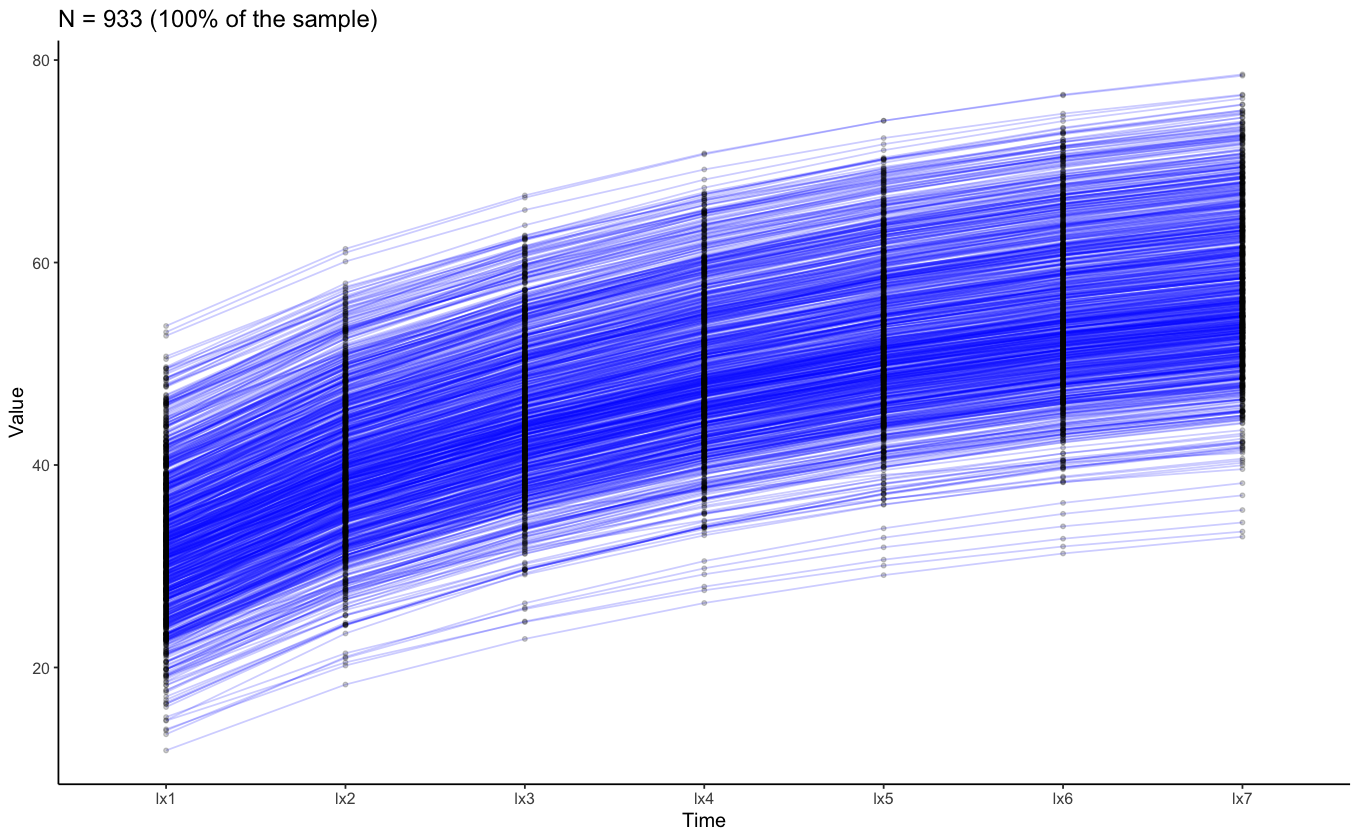

In [41]:
plot_trajectories(
    data = dd,
    id_var = "id",
    var_list = vlist,
    xlab = "Time", ylab = "Value",
    connect_missing = FALSE,
    # random_sample_frac = 0.018,
    title_n = TRUE
)

Come si vede dalla figura, tutte le traiettorie previste mostrano la forma generale di crescita che era stata descritta in precedenza.

La varianza del punteggio vero iniziale è 72.01 e descrive la variabilità inter-personale dei punteggi veri di matematica per il grado 2 (seconda elementare). 

La varianza della componente di cambiamento costante è 5.84 e rappresenta la variabilità tra i bambini in questo aspetto del cambiamento (di nuovo i parametri associati alla componente di cambiamento costante sono difficili da interpretare isolatamente). 

La covarianza tra il punteggio vero iniziale e la componente di cambiamento costante era 13.62, indicando che i bambini con punteggi veri di matematica più alti al  grado 2 tendevano ad avere punteggi nella componente di cambiamento costante più elevati, il che rivela un cambiamento complessivo maggiore dal secondo all’ottavo grado. 

Infine, la varianza dei punteggi unici era 30.78 e indica l’entità delle fluttuazioni intra-personali attorno alle traiettorie individuali predette dal modello.